# Road lengths from *.osm.pbf files

This is a simplified version for smaller geographical areas.

In [1]:
# Import packages

from sqlalchemy import create_engine
from pandas import read_sql, DataFrame, merge
from geopandas import read_postgis, GeoDataFrame
from numpy import arange, array
from shapely import geometry
from matplotlib.pyplot import imshow, plot, subplots
import cartopy
from osmnx.geometries import geometries_from_place

In [2]:
# Getting München: direct download using the osmnx package

munich = geometries_from_place('Munchen, Germany', {'highway':['motorway',
                                                                'trunk',
                                                                'primary',
                                                                'secondary',
                                                                'tertiary',
                                                                'unclassified',
                                                                'residential',
                                                                'motorway_link',
                                                                'trunk_link',
                                                                'primary_link',
                                                                'secondary_link',
                                                                'tertiary_link']})

In [3]:
munich.reset_index(drop=True,inplace=True)
munich = munich[munich.geom_type != 'Point'] # Removing nodes
munich = munich[['highway', 'geometry']] # Keeping only highway type and geometry

In [4]:
# Function to create grid. This one gets the square_size in meters

def drawGrid(geom_bounds, square_size, proj):
    '''
    Creates a grid with squared grid cells around a defined geometry in geografical coordinates or projected if specified.
    square_size: size of the cell in degrees
    '''

    geom_bounds = geom_bounds.to_crs(proj)

    total_bounds = geom_bounds.total_bounds
    minX, minY, maxX, maxY = total_bounds
    x, y = (minX, minY)
    geom_array = []

    while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size

    grid = GeoDataFrame(geom_array, columns=['geometry'])
    grid = grid.set_crs(proj)

    return grid

In [5]:
# Getting the grid in Mercator

grid = drawGrid(munich, 1000, 'EPSG:3395')

In [6]:
grid.loc[:,'cell_idx'] = arange(0,grid.shape[0]) # Preparing grid to spatial join with highways

# Calculating the length of each road segment

munich_proj = munich.to_crs("EPSG:3395") # Projection needed to calculate distance
munich_proj['length'] = munich_proj.length

In [7]:
# Spatial join of grid with highways to define what is inside each grid cell

lengths = grid.sjoin(munich_proj, how='inner')

In [8]:
total = merge(grid, lengths.groupby(['cell_idx'], as_index=False).sum(), on='cell_idx')
total

,geometry,cell_idx,index_right,length
0,"POLYGON ((1277434.453 6085873.033, 1277434.453...",12,13975,856.671012
1,"POLYGON ((1281434.453 6085873.033, 1281434.453...",16,218182,5608.206129
2,"POLYGON ((1282434.453 6085873.033, 1282434.453...",17,156246,5166.546185
3,"POLYGON ((1284434.453 6085873.033, 1284434.453...",19,19579,1072.751090
4,"POLYGON ((1277434.453 6086873.033, 1277434.453...",51,13975,856.671012
...,...,...,...,...
726,"POLYGON ((1280434.453 6113873.033, 1280434.453...",1107,7203,3094.190630
727,"POLYGON ((1284434.453 6113873.033, 1284434.453...",1111,4620,2541.461691
728,"POLYGON ((1280434.453 6114873.033, 1280434.453...",1146,26228,3677.284522
729,"POLYGON ((1281434.453 6114873.033, 1281434.453...",1147,21452,3027.149888


/home/carlos/miniconda3/envs/ffdas/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/carlos/miniconda3/envs/ffdas/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/carlos/miniconda3/envs/ffdas/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/carlos/miniconda3/envs/ffdas/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/carlos/miniconda3/en

Text(0.5, 1.0, 'München')

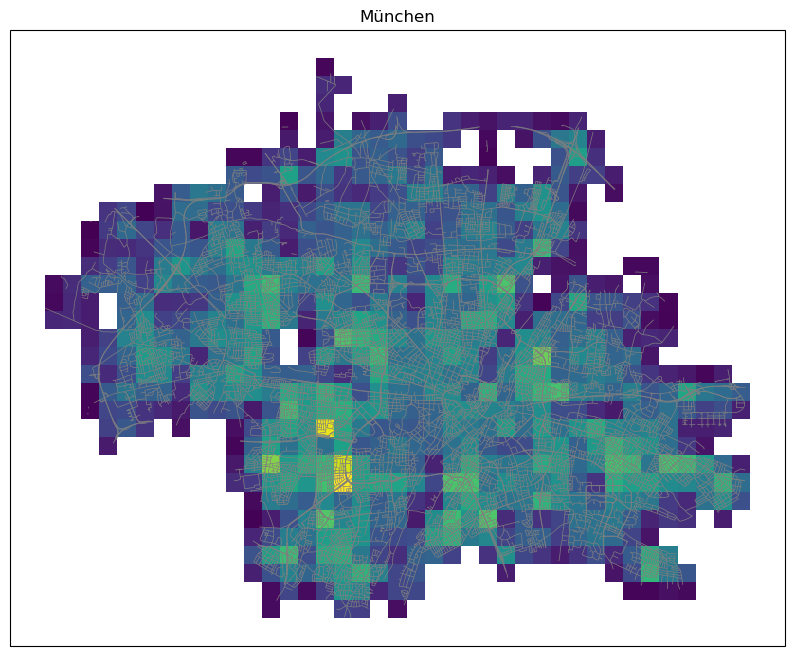

In [9]:
f, ax = subplots( 1, 1, subplot_kw=dict(projection=cartopy.crs.Mercator()), figsize=(10,10))

munich_proj.plot(ax=ax, lw=0.5, edgecolor='gray')
total.plot(ax=ax, column='length')
ax.set_title('München')
# ax[1].set_title('Lengths')


In [10]:
# Saving to shapefile

total.to_file('munich_grided.shp')

/home/carlos/miniconda3/envs/ffdas/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_24542/39689054.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  total.to_file('munich_grided.shp')
/home/carlos/miniconda3/envs/ffdas/lib/python3.9/site-packages/geopandas/io/file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:
